Для задачи Style Transfer возмём предобученную на датасете ImageNet сеть VGG19 и дообучим её на датасете Caltech

## Загрузка данных

In [1]:
# установим недостающие библиотеки
# ! pip install torchinfo
# ! pip install GoogleDriveDownloader

In [2]:
# импортируем библиотеки
import os
import cv2
import copy
import torch
import shutil
import random
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
from torchinfo import summary
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
import matplotlib.patches as patches
from py_essentials import hashing as hs
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from matplotlib.font_manager import FontProperties
from sklearn.model_selection import train_test_split
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
# зафиксируем random seed
SEED = 42
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Определим device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

C:\Users\Tsinovkin.A.ITRND\Anaconda3\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [5]:
# Выведем информацию о видеоадаптере при его наличии
if device.type == 'cuda':
    !nvidia-smi

Thu Jan 20 23:16:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 29%   37C    P8     9W / 160W |    265MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# Загрузим и распакуем датасет Caltech101
# http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html

gdd.download_file_from_google_drive(file_id='1wUwxL7Ahfi6zwVH8jaMvKJxo82xo7Jtq',
                                    dest_path='./caltech_101', unzip=True)

Unzipping...Done.


In [17]:
# Загрузим и распакуем датасет Caltech256
# http://www.vision.caltech.edu/Image_Datasets/Caltech256/

gdd.download_file_from_google_drive(file_id='13Cqfw84-yM7FYstfSJt0GUCoP2CnFc3q',
                                    dest_path='./caltech_256', unzip=True)

Unzipping...Done.


In [5]:
BASE_DIR = Path('./')                             # базовая директория
CALTECH_101_DIR = Path('./101_ObjectCategories')  # директория для датасета Caltech101
CALTECH_256_DIR = Path('./256_ObjectCategories')  # директория для датасета Caltech256

In [51]:
# yдалим класс 'BACKGROUND_Google' в датасете Caltech101. 
# в нём изображения не имеют выраженного класса и для задачи Style Transfer могут только навредить
shutil.rmtree(CALTECH_101_DIR / 'BACKGROUND_Google')

In [6]:
# определим с каким датасетом работаем
DATA_DIR = CALTECH_101_DIR

## Exploration data analysis

### Создание датафрейма

In [8]:
classes = []
files = []

for folder in os.listdir(DATA_DIR):
    for file in os.listdir(os.path.join(DATA_DIR, folder)):
        classes.append(folder)
        files.append(os.path.join(folder, file))

In [9]:
data_df = pd.DataFrame(data={'class':classes, 'image_path':files})
data_df.head()

,class,image_path
0,accordion,accordion\image_0001.jpg
1,accordion,accordion\image_0002.jpg
2,accordion,accordion\image_0003.jpg
3,accordion,accordion\image_0004.jpg
4,accordion,accordion\image_0005.jpg


In [10]:
data_df.describe()

,class,image_path
count,8677,8677
unique,101,8677
top,airplanes,airplanes\image_0502.jpg
freq,800,1


Датасет содержит 8677 изображений в 101 классу. Наиболее часто встречающийся класс - "airplanes" с 800 изображениями.

### Пропорции классов

In [11]:
classcount = data_df.groupby('class').count().reset_index()
classcount = classcount.rename(columns={"class": "class", "image_path": "count"}).sort_values("count")
classcount.head()

,class,count
52,inline_skate,31
64,metronome,32
11,binocular,33
43,garfield,34
97,wild_cat,34


In [12]:
classcount.tail()

,class,count
94,watch,239
1,Faces_easy,435
0,Faces,435
3,Motorbikes,798
5,airplanes,800


In [13]:
classcount.describe(include='all')

,class,count
count,101,101.000000
unique,101,NaN
top,Faces,NaN
freq,1,NaN
mean,NaN,85.910891
std,NaN,118.337830
min,NaN,31.000000
25%,NaN,45.000000
50%,NaN,59.000000
75%,NaN,80.000000


Максимальное количествое изображений в классе - 800. Минимальное - 31. Вероятно потребуется дополнительная балансировка классов.

### Статистики изображений

In [14]:
image_info = []

for file in data_df.image_path:
    with Image.open(DATA_DIR / file) as img:
        width, height = img.size
        mode = img.mode
        file_hash = hs.fileChecksum(DATA_DIR / file, "sha256")    
        image_info.append((width, height, mode, file_hash))
        
print(f'Обработано {len(image_info)} файлов')

data_df['width'], data_df['height'], data_df['mode'], data_df['hash'] = zip(*image_info)
data_df['aspect_ratio'] = data_df['width'] / data_df['height']
data_df.head()

Обработано 8677 файлов


,class,image_path,width,height,mode,hash,aspect_ratio
0,accordion,accordion\image_0001.jpg,260,300,RGB,e1f77ff1e327056e0a3998a8b60b347c2d2ac325458fb9...,0.866667
1,accordion,accordion\image_0002.jpg,232,300,RGB,aa8e1a5f36e43a4d075da5bbd451e2d446fabe70e6334e...,0.773333
2,accordion,accordion\image_0003.jpg,300,282,RGB,c4a46049990aee726c12be448cd1df928fec9d9b2f39ed...,1.063830
3,accordion,accordion\image_0004.jpg,300,199,RGB,9fe627df37dd9584d1237d8efad00fe656de7e0da43e8d...,1.507538
4,accordion,accordion\image_0005.jpg,223,300,RGB,987c1753c43180c5dcc2629a0b1fdf708fe25a7d854585...,0.743333


In [15]:
data_df.describe(include='all')

,class,image_path,width,height,mode,hash,aspect_ratio
count,8677,8677,8677.000000,8677.000000,8677,8677,8677.000000
unique,101,8677,NaN,NaN,2,8677,NaN
top,airplanes,airplanes\image_0502.jpg,NaN,NaN,RGB,8813f308db843d834f3622a021efd36fd1539c72a147c2...,NaN
freq,800,1,NaN,NaN,8296,1,NaN
mean,NaN,NaN,297.759594,239.519419,NaN,NaN,1.357297
std,NaN,NaN,70.197753,63.763222,NaN,NaN,0.547179
min,NaN,NaN,80.000000,92.000000,NaN,NaN,0.266667
25%,NaN,NaN,262.000000,185.000000,NaN,NaN,0.946667
50%,NaN,NaN,300.000000,240.000000,NaN,NaN,1.331633
75%,NaN,NaN,300.000000,300.000000,NaN,NaN,1.530612


Датасет не содержит дубликатов, но часть изображений имеет не RGB формат

### Размеры и пропорции изображений

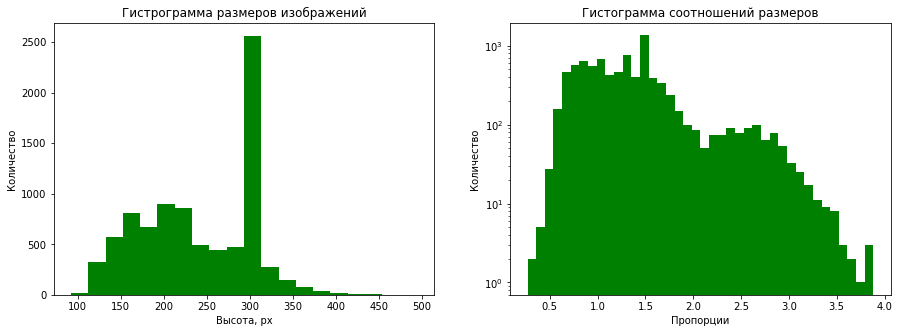

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(data_df.height, bins=20, color='green')
plt.title('Гистрограмма размеров изображений')
plt.xlabel('Высота, px')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.hist(data_df.aspect_ratio, bins=40, log=True, color='green')
plt.title('Гистограмма соотношений размеров')
plt.xlabel('Пропорции')
plt.ylabel('Количество')

plt.show()

Большинство изображение имеют размеры от 100px до 350px. Пропорции совершенно различные, как альбомные, так и портретные.

### Уровень яркости изображений

In [19]:
brightness = []

for file in data_df.image_path:
    image = cv2.imread(str(DATA_DIR / file))
    hsld  = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    Bchannels = hsld[:,:,1]
    Blevel = cv2.mean(Bchannels)[0]
    brightness.append(Blevel)
    
data_df['brightness'] = brightness
data_df.head()

,class,image_path,width,height,mode,hash,aspect_ratio,brightness
0,accordion,accordion\image_0001.jpg,260,300,RGB,e1f77ff1e327056e0a3998a8b60b347c2d2ac325458fb9...,0.866667,75.039128
1,accordion,accordion\image_0002.jpg,232,300,RGB,aa8e1a5f36e43a4d075da5bbd451e2d446fabe70e6334e...,0.773333,47.223046
2,accordion,accordion\image_0003.jpg,300,282,RGB,c4a46049990aee726c12be448cd1df928fec9d9b2f39ed...,1.063830,122.262861
3,accordion,accordion\image_0004.jpg,300,199,RGB,9fe627df37dd9584d1237d8efad00fe656de7e0da43e8d...,1.507538,78.237538
4,accordion,accordion\image_0005.jpg,223,300,RGB,987c1753c43180c5dcc2629a0b1fdf708fe25a7d854585...,0.743333,38.609925


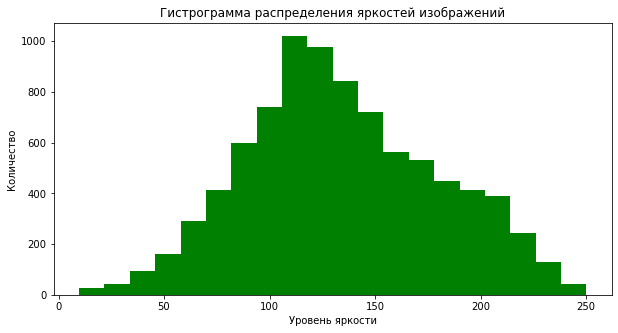

In [20]:
plt.figure(figsize=(10, 5))

plt.hist(data_df.brightness, bins=20, color='green')
plt.title('Гистрограмма распределения яркостей изображений')
plt.xlabel('Уровень яркости')
plt.ylabel('Количество')
plt.show()

Отобразим самое яркое и самое затемнённое изображения

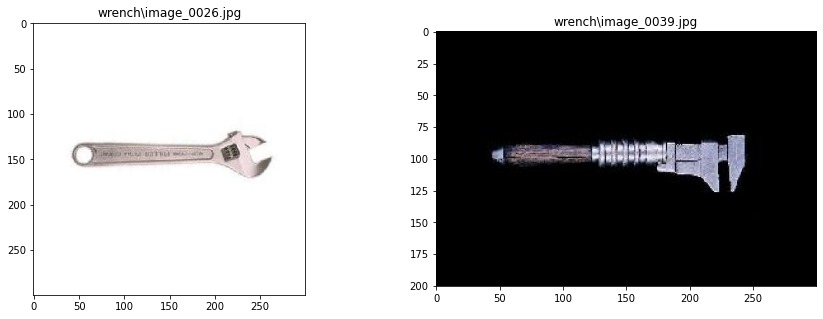

In [21]:
plt.figure(figsize=(15, 5))
bright_df = data_df.sort_values(['brightness'], ascending=False).iloc[[0, -1]]
i = 0

for file in bright_df.image_path:
    i += 1
    plt.subplot(1, 2, i)
    image = Image.open(DATA_DIR / file)
    plt.imshow(image)
    plt.title(file)
plt.show()

Уровень яркости пограничных изображений вполне допустим. Визуально персонаж на картинке определяется без затруднений

### Сохранение датафрейма

In [23]:
data_df.to_csv(BASE_DIR / 'data_df.csv', sep=',', index_label='index')

In [7]:
data_df = pd.read_csv(BASE_DIR / 'data_df.csv', sep=',', index_col='index')
data_df.drop(['hash'], inplace=True, axis=1)  # удалим не нужный более столбец
data_df.head()

,class,image_path,width,height,mode,aspect_ratio,brightness
index,,,,,,,
0,accordion,accordion\image_0001.jpg,260,300,RGB,0.866667,75.039128
1,accordion,accordion\image_0002.jpg,232,300,RGB,0.773333,47.223046
2,accordion,accordion\image_0003.jpg,300,282,RGB,1.063830,122.262861
3,accordion,accordion\image_0004.jpg,300,199,RGB,1.507538,78.237538
4,accordion,accordion\image_0005.jpg,223,300,RGB,0.743333,38.609925


## Подготовка данных для обучения модели

In [8]:
# cоздадим список всех файлов обучающего датасета
train_val_files = sorted(list(DATA_DIR.rglob('*.jpg')))

In [9]:
# обучим Label Encoder на всём датасете
label_encoder = LabelEncoder()
train_val_labels = [path.parent.name for path in train_val_files]  # path.parent.name[4:] для Caltech256
label_encoder.fit(train_val_labels)

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# количество классов:
n_classes = len(np.unique(train_val_labels))

In [11]:
class ImageDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # размер, в который нужно преобразовать изображение
        self.rescale_size = rescale_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        
        self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        image = ImageOps.pad(image, (self.rescale_size, self.rescale_size))
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.CenterCrop(self.rescale_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=(0, 5)),
                transforms.RandAugment(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])      
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
# разобъём данные на тренировочную и валидационную части
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [14]:
# создадим тренировочный и валидационный датасеты
train_dataset = ImageDataset(train_files, mode='train', rescale_size=RESCALE_SIZE)
val_dataset = ImageDataset(val_files, mode='val', rescale_size=RESCALE_SIZE)

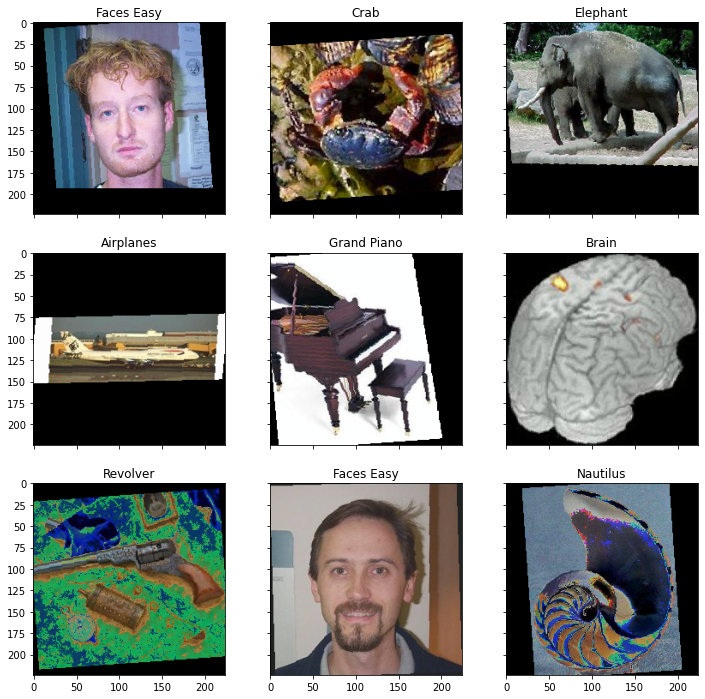

In [15]:
# взглянем на изображения внутри тренировочного датасета
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_picture = int(np.random.uniform(0, len(train_dataset)))
    im_val, label = train_dataset[random_picture]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

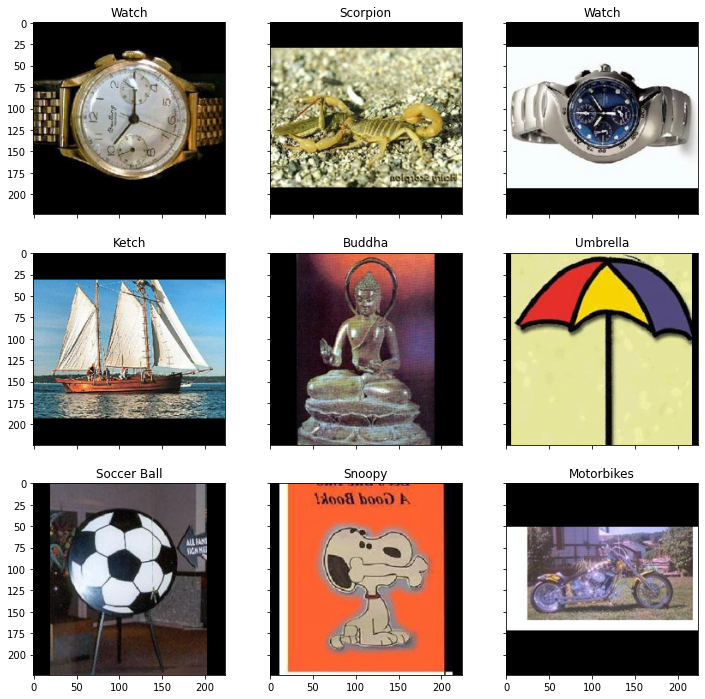

In [16]:
# взглянем на изображения внутри валидационного датасета
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_picture = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_picture]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

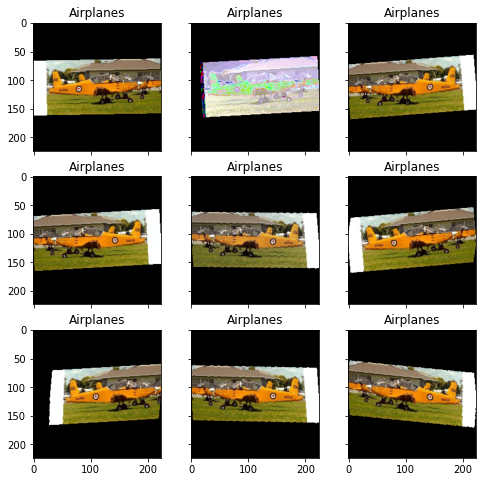

In [17]:
# взглянем как изменяется изображение под действием аугментаций
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(41, 42))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), title=img_label,plt_ax=fig_x)

### OverSampling

Т.к. классы не сбалансированны, проведём семпилирование недостающих классов

In [18]:
# список классов для train и val
train_labels = [path.parent.name for path in train_files]  # path.parent.name[4:] для Caltech256
val_labels = [path.parent.name for path in val_files]      # path.parent.name[4:] для Caltech256

In [19]:
def create_dct_path_labels(train_files, train_labels):
    '''Создаёт словарь, в котором ключ - метка класса, 
    значение - список путей к файлам данного класса'''
    dct_images = {}
    for label_i in np.unique(train_labels).tolist():
        dct_images[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_images[label_i].append(path_i)

    return dct_images

def print_dct(dct_images):
    '''Распечатывает словарь'''
    for key in dct_images:
        print(f"{key}\t{dct_images[key]}")

In [20]:
# создадим словарь
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [21]:
# дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for label_i in dct_path_train:
    if len(dct_path_train[label_i]) < 100:
        dct_path_train[label_i] = dct_path_train[label_i] * (100 // len(dct_path_train[label_i]))
        dct_path_train[label_i].extend(dct_path_train[label_i][:100 - len(dct_path_train[label_i])])

In [22]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими количеству этих классов в 
    list train_val_labels"""
    dct_images = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_images.update({label_i:train_val_labels.count(label_i)})

    return dct_images

In [23]:
# подготовим новый список тренировочных файлов
new_train_files = []

for label_i in dct_path_train:
    new_train_files.extend(dct_path_train[label_i])

new_train_label = [path.parent.name for path in new_train_files]  # path.parent.name[4:] для Caltech256

In [24]:
# класс:количество картинок для train
sampling_df = pd.DataFrame.from_records([create_dct_from_labels(new_train_label)]).T.reset_index()
sampling_df.rename(columns={"index": "class", 0: "count"}, inplace=True)
sampling_df

,class,count
0,Faces,326
1,Faces_easy,326
2,Leopards,150
3,Motorbikes,598
4,accordion,100
...,...,...
96,wheelchair,100
97,wild_cat,100
98,windsor_chair,100
99,wrench,100


## Обучение модели

### Подготовка

In [25]:
# создадим датасеты, после оверсемплинга
train_dataset = ImageDataset(new_train_files, mode='train', rescale_size=RESCALE_SIZE)
val_dataset = ImageDataset(val_files, mode='val', rescale_size=RESCALE_SIZE)

In [26]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    lb = torch.tensor([])
    pr = torch.tensor([])
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        lb = torch.cat((lb, labels.data.cpu()))
        pr = torch.cat((pr, preds.cpu()))
        
        # очистка кеша
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
        torch.cuda.empty_cache()
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score(lb.numpy(), pr.numpy(), average='weighted')
    
    return train_loss, train_acc, train_f1

In [27]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    lb = torch.tensor([])
    pr = torch.tensor([])

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        lb = torch.cat((lb, labels.data.cpu()))
        pr = torch.cat((pr, preds.cpu()))
        
        # очистка кеша
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
        torch.cuda.empty_cache()
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(lb.numpy(), pr.numpy(), average='weighted')
    
    return val_loss, val_acc, val_f1

In [28]:
def train(train_files, val_files, model, epochs, batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    best_model_weights = model.state_dict()
    best_acc = 0.0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} \
    train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f} \
    train_f1: {t_f1:0.4f} val_f1: {v_f1:0.4f}" 

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))

            # сохранение лучших весов модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_weights = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc,\
                                           t_f1=train_f1, v_f1=val_f1))
            scheduler.step()
            torch.cuda.empty_cache()
    
    # загрузим лучшие веса
    model.load_state_dict(best_model_weights)
          
    return history

In [29]:
# Загрузим предобученную VGG
vgg19 = models.vgg19(pretrained=True, progress=True)
vgg19.classifier[-1] = nn.Linear(4096, n_classes)
vgg19 = vgg19.to(device)
summary(vgg19, (64, 3, RESCALE_SIZE, RESCALE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [64, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [64, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [64, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [64, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [64, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [64, 256, 56, 56]         29

### Обучение

In [31]:
history = train(train_dataset, val_dataset, vgg19, epochs=50, batch_size=16)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 1.7562116168676067


epoch:   2%|▏         | 1/50 [08:17<6:46:10, 497.35s/it]


Epoch 001 train_loss: 1.7562 val_loss: 0.6244     train_acc: 0.5734 val_acc: 0.8304     train_f1: 0.5650 val_f1: 0.8253
loss 0.4074822086472454


epoch:   4%|▍         | 2/50 [16:36<6:38:39, 498.31s/it]


Epoch 002 train_loss: 0.4075 val_loss: 0.4117     train_acc: 0.8851 val_acc: 0.8862     train_f1: 0.8850 val_f1: 0.8844
loss 0.21598562420679887


epoch:   6%|▌         | 3/50 [24:52<6:29:32, 497.29s/it]


Epoch 003 train_loss: 0.2160 val_loss: 0.3681     train_acc: 0.9351 val_acc: 0.9088     train_f1: 0.9351 val_f1: 0.9077
loss 0.12534419860299012


epoch:   8%|▊         | 4/50 [33:12<6:22:03, 498.33s/it]


Epoch 004 train_loss: 0.1253 val_loss: 0.3489     train_acc: 0.9641 val_acc: 0.9249     train_f1: 0.9642 val_f1: 0.9240
loss 0.08448379656569466


epoch:  10%|█         | 5/50 [41:31<6:13:52, 498.50s/it]


Epoch 005 train_loss: 0.0845 val_loss: 0.3444     train_acc: 0.9761 val_acc: 0.9217     train_f1: 0.9761 val_f1: 0.9215
loss 0.06237320602137021


epoch:  12%|█▏        | 6/50 [49:51<6:05:57, 499.03s/it]


Epoch 006 train_loss: 0.0624 val_loss: 0.3122     train_acc: 0.9805 val_acc: 0.9327     train_f1: 0.9805 val_f1: 0.9324
loss 0.041673722421881186


epoch:  14%|█▍        | 7/50 [58:12<5:58:14, 499.88s/it]


Epoch 007 train_loss: 0.0417 val_loss: 0.2917     train_acc: 0.9878 val_acc: 0.9392     train_f1: 0.9878 val_f1: 0.9389
loss 0.03007479016666721


epoch:  16%|█▌        | 8/50 [1:06:28<5:48:54, 498.43s/it]


Epoch 008 train_loss: 0.0301 val_loss: 0.2641     train_acc: 0.9912 val_acc: 0.9364     train_f1: 0.9912 val_f1: 0.9366
loss 0.016214675801785164


epoch:  18%|█▊        | 9/50 [1:14:41<5:39:25, 496.71s/it]


Epoch 009 train_loss: 0.0162 val_loss: 0.3306     train_acc: 0.9949 val_acc: 0.9382     train_f1: 0.9949 val_f1: 0.9381
loss 0.01927963601237583


epoch:  20%|██        | 10/50 [1:22:54<5:30:27, 495.69s/it]


Epoch 010 train_loss: 0.0193 val_loss: 0.2669     train_acc: 0.9942 val_acc: 0.9382     train_f1: 0.9942 val_f1: 0.9382
loss 0.010183329566943155


epoch:  22%|██▏       | 11/50 [1:31:08<5:21:51, 495.18s/it]


Epoch 011 train_loss: 0.0102 val_loss: 0.2785     train_acc: 0.9971 val_acc: 0.9456     train_f1: 0.9971 val_f1: 0.9455
loss 0.007200315122067083


epoch:  24%|██▍       | 12/50 [1:39:21<5:13:10, 494.50s/it]


Epoch 012 train_loss: 0.0072 val_loss: 0.2826     train_acc: 0.9979 val_acc: 0.9470     train_f1: 0.9979 val_f1: 0.9472
loss 0.0058394164088153245


epoch:  26%|██▌       | 13/50 [1:47:35<5:04:49, 494.31s/it]


Epoch 013 train_loss: 0.0058 val_loss: 0.2869     train_acc: 0.9984 val_acc: 0.9484     train_f1: 0.9984 val_f1: 0.9484
loss 0.007659101462381864


epoch:  28%|██▊       | 14/50 [1:55:48<4:56:20, 493.92s/it]


Epoch 014 train_loss: 0.0077 val_loss: 0.2796     train_acc: 0.9976 val_acc: 0.9470     train_f1: 0.9976 val_f1: 0.9466
loss 0.0054230540762760515


epoch:  30%|███       | 15/50 [2:04:01<4:47:55, 493.59s/it]


Epoch 015 train_loss: 0.0054 val_loss: 0.2951     train_acc: 0.9985 val_acc: 0.9475     train_f1: 0.9985 val_f1: 0.9470
loss 0.005939040848425918


epoch:  32%|███▏      | 16/50 [2:12:13<4:39:31, 493.28s/it]


Epoch 016 train_loss: 0.0059 val_loss: 0.2951     train_acc: 0.9983 val_acc: 0.9447     train_f1: 0.9983 val_f1: 0.9445
loss 0.003517706095997535


epoch:  34%|███▍      | 17/50 [2:20:26<4:31:16, 493.21s/it]


Epoch 017 train_loss: 0.0035 val_loss: 0.3041     train_acc: 0.9990 val_acc: 0.9465     train_f1: 0.9990 val_f1: 0.9465
loss 0.002215067942244239


epoch:  36%|███▌      | 18/50 [2:28:39<4:23:02, 493.21s/it]


Epoch 018 train_loss: 0.0022 val_loss: 0.2929     train_acc: 0.9995 val_acc: 0.9502     train_f1: 0.9995 val_f1: 0.9499
loss 0.003395788875135407


epoch:  38%|███▊      | 19/50 [2:36:52<4:14:45, 493.08s/it]


Epoch 019 train_loss: 0.0034 val_loss: 0.3106     train_acc: 0.9992 val_acc: 0.9502     train_f1: 0.9992 val_f1: 0.9500
loss 0.0016666440688651303


epoch:  40%|████      | 20/50 [2:45:05<4:06:26, 492.88s/it]


Epoch 020 train_loss: 0.0017 val_loss: 0.3148     train_acc: 0.9997 val_acc: 0.9502     train_f1: 0.9997 val_f1: 0.9499
loss 0.0020332590066158463


epoch:  42%|████▏     | 21/50 [2:53:17<3:58:08, 492.71s/it]


Epoch 021 train_loss: 0.0020 val_loss: 0.3322     train_acc: 0.9992 val_acc: 0.9484     train_f1: 0.9992 val_f1: 0.9482
loss 0.0031624110448692302


epoch:  44%|████▍     | 22/50 [3:01:30<3:49:55, 492.68s/it]


Epoch 022 train_loss: 0.0032 val_loss: 0.3116     train_acc: 0.9992 val_acc: 0.9507     train_f1: 0.9992 val_f1: 0.9505
loss 0.00186020891823666


epoch:  46%|████▌     | 23/50 [3:09:43<3:41:44, 492.75s/it]


Epoch 023 train_loss: 0.0019 val_loss: 0.3124     train_acc: 0.9994 val_acc: 0.9484     train_f1: 0.9994 val_f1: 0.9480
loss 0.004644645689014194


epoch:  48%|████▊     | 24/50 [3:17:56<3:33:33, 492.82s/it]


Epoch 024 train_loss: 0.0046 val_loss: 0.3003     train_acc: 0.9987 val_acc: 0.9498     train_f1: 0.9987 val_f1: 0.9494
loss 0.0018023422951890169


epoch:  50%|█████     | 25/50 [3:26:08<3:25:19, 492.80s/it]


Epoch 025 train_loss: 0.0018 val_loss: 0.2966     train_acc: 0.9994 val_acc: 0.9512     train_f1: 0.9994 val_f1: 0.9508
loss 0.001679951466252562


epoch:  52%|█████▏    | 26/50 [3:34:21<3:17:05, 492.74s/it]


Epoch 026 train_loss: 0.0017 val_loss: 0.3021     train_acc: 0.9995 val_acc: 0.9498     train_f1: 0.9995 val_f1: 0.9494
loss 0.002299430389532415


epoch:  54%|█████▍    | 27/50 [3:42:35<3:09:03, 493.21s/it]


Epoch 027 train_loss: 0.0023 val_loss: 0.2991     train_acc: 0.9993 val_acc: 0.9507     train_f1: 0.9993 val_f1: 0.9506
loss 0.002704159268607028


epoch:  56%|█████▌    | 28/50 [3:50:48<3:00:50, 493.21s/it]


Epoch 028 train_loss: 0.0027 val_loss: 0.3045     train_acc: 0.9993 val_acc: 0.9507     train_f1: 0.9993 val_f1: 0.9505
loss 0.002325379708835359


epoch:  58%|█████▊    | 29/50 [3:59:01<2:52:36, 493.17s/it]


Epoch 029 train_loss: 0.0023 val_loss: 0.3090     train_acc: 0.9993 val_acc: 0.9498     train_f1: 0.9993 val_f1: 0.9496
loss 0.0023559176557125193


epoch:  60%|██████    | 30/50 [4:07:14<2:44:21, 493.07s/it]


Epoch 030 train_loss: 0.0024 val_loss: 0.3067     train_acc: 0.9996 val_acc: 0.9498     train_f1: 0.9996 val_f1: 0.9495
loss 0.0038239050699958076


epoch:  62%|██████▏   | 31/50 [4:15:27<2:36:07, 493.04s/it]


Epoch 031 train_loss: 0.0038 val_loss: 0.2942     train_acc: 0.9990 val_acc: 0.9512     train_f1: 0.9990 val_f1: 0.9511
loss 0.0024129396765948156


epoch:  64%|██████▍   | 32/50 [4:23:40<2:27:55, 493.08s/it]


Epoch 032 train_loss: 0.0024 val_loss: 0.2933     train_acc: 0.9993 val_acc: 0.9535     train_f1: 0.9993 val_f1: 0.9534
loss 0.001332065356905866


epoch:  66%|██████▌   | 33/50 [4:31:53<2:19:39, 492.94s/it]


Epoch 033 train_loss: 0.0013 val_loss: 0.2938     train_acc: 0.9996 val_acc: 0.9521     train_f1: 0.9996 val_f1: 0.9520
loss 0.0016551984248407673


epoch:  68%|██████▊   | 34/50 [4:40:06<2:11:25, 492.86s/it]


Epoch 034 train_loss: 0.0017 val_loss: 0.2967     train_acc: 0.9996 val_acc: 0.9507     train_f1: 0.9996 val_f1: 0.9507
loss 0.0009725814768397758


epoch:  70%|███████   | 35/50 [4:48:19<2:03:12, 492.86s/it]


Epoch 035 train_loss: 0.0010 val_loss: 0.2973     train_acc: 0.9996 val_acc: 0.9525     train_f1: 0.9996 val_f1: 0.9525
loss 0.0017843953208699248


epoch:  72%|███████▏  | 36/50 [4:56:32<1:55:03, 493.13s/it]


Epoch 036 train_loss: 0.0018 val_loss: 0.2975     train_acc: 0.9994 val_acc: 0.9516     train_f1: 0.9994 val_f1: 0.9515
loss 0.0013259408401139969


epoch:  74%|███████▍  | 37/50 [5:04:46<1:46:50, 493.15s/it]


Epoch 037 train_loss: 0.0013 val_loss: 0.2972     train_acc: 0.9996 val_acc: 0.9516     train_f1: 0.9996 val_f1: 0.9515
loss 0.003050995287088873


epoch:  76%|███████▌  | 38/50 [5:12:58<1:38:35, 492.98s/it]


Epoch 038 train_loss: 0.0031 val_loss: 0.2963     train_acc: 0.9990 val_acc: 0.9535     train_f1: 0.9990 val_f1: 0.9534
loss 0.0015621080759983242


epoch:  78%|███████▊  | 39/50 [5:21:11<1:30:23, 493.03s/it]


Epoch 039 train_loss: 0.0016 val_loss: 0.2966     train_acc: 0.9995 val_acc: 0.9530     train_f1: 0.9995 val_f1: 0.9529
loss 0.0008045112964675449


epoch:  80%|████████  | 40/50 [5:29:25<1:22:13, 493.33s/it]


Epoch 040 train_loss: 0.0008 val_loss: 0.2981     train_acc: 0.9996 val_acc: 0.9535     train_f1: 0.9996 val_f1: 0.9533
loss 0.0014785957669800453


epoch:  82%|████████▏ | 41/50 [5:37:39<1:14:01, 493.50s/it]


Epoch 041 train_loss: 0.0015 val_loss: 0.2990     train_acc: 0.9995 val_acc: 0.9530     train_f1: 0.9995 val_f1: 0.9528
loss 0.002273828191441522


epoch:  84%|████████▍ | 42/50 [5:45:53<1:05:47, 493.49s/it]


Epoch 042 train_loss: 0.0023 val_loss: 0.2980     train_acc: 0.9993 val_acc: 0.9535     train_f1: 0.9993 val_f1: 0.9533
loss 0.000810564544904305


epoch:  86%|████████▌ | 43/50 [5:54:06<57:33, 493.39s/it]  


Epoch 043 train_loss: 0.0008 val_loss: 0.2980     train_acc: 0.9997 val_acc: 0.9539     train_f1: 0.9997 val_f1: 0.9538
loss 0.0016626224824490055


epoch:  88%|████████▊ | 44/50 [6:02:19<49:19, 493.24s/it]


Epoch 044 train_loss: 0.0017 val_loss: 0.2980     train_acc: 0.9997 val_acc: 0.9530     train_f1: 0.9997 val_f1: 0.9528
loss 0.001279084924115515


epoch:  90%|█████████ | 45/50 [6:10:34<41:08, 493.72s/it]


Epoch 045 train_loss: 0.0013 val_loss: 0.2986     train_acc: 0.9997 val_acc: 0.9539     train_f1: 0.9997 val_f1: 0.9538
loss 0.001470832889452888


epoch:  92%|█████████▏| 46/50 [6:18:48<32:55, 493.85s/it]


Epoch 046 train_loss: 0.0015 val_loss: 0.2987     train_acc: 0.9995 val_acc: 0.9539     train_f1: 0.9995 val_f1: 0.9537
loss 0.002375608829338587


epoch:  94%|█████████▍| 47/50 [6:27:01<24:41, 493.72s/it]


Epoch 047 train_loss: 0.0024 val_loss: 0.2984     train_acc: 0.9994 val_acc: 0.9539     train_f1: 0.9994 val_f1: 0.9538
loss 0.0011430407161293046


epoch:  96%|█████████▌| 48/50 [6:35:14<16:27, 493.59s/it]


Epoch 048 train_loss: 0.0011 val_loss: 0.2984     train_acc: 0.9996 val_acc: 0.9539     train_f1: 0.9996 val_f1: 0.9537
loss 0.0009179641181468499


epoch:  98%|█████████▊| 49/50 [6:43:28<08:13, 493.49s/it]


Epoch 049 train_loss: 0.0009 val_loss: 0.2982     train_acc: 0.9997 val_acc: 0.9539     train_f1: 0.9997 val_f1: 0.9537
loss 0.0016570283622134622


epoch: 100%|██████████| 50/50 [6:51:41<00:00, 494.02s/it]


Epoch 050 train_loss: 0.0017 val_loss: 0.2985     train_acc: 0.9997 val_acc: 0.9544     train_f1: 0.9997 val_f1: 0.9542


In [32]:
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*history)

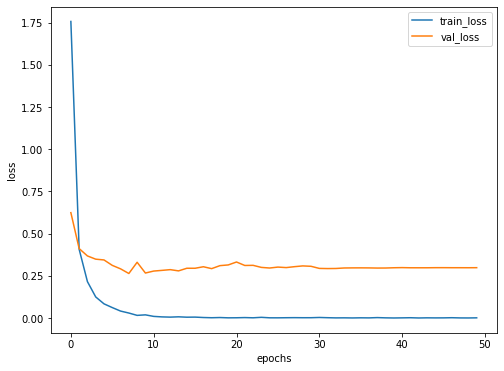

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

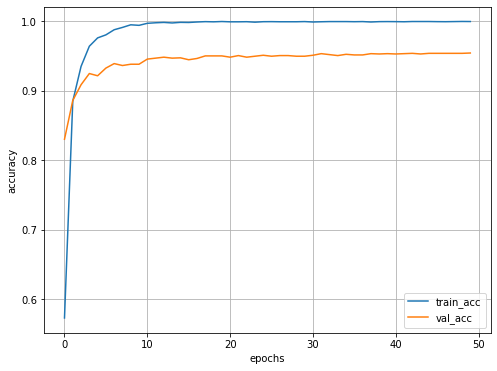

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [59]:
torch.save(vgg19.state_dict(), Path(BASE_DIR) / 'vgg19_50ep_101.pth')

In [30]:
# загрузка весов
vgg19.load_state_dict(torch.load(Path(BASE_DIR) / 'vgg19_50ep_101.pth', map_location=device))
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [31]:
vgg19_ft = copy.deepcopy(vgg19.features[:11])  # [:16] for vgg19_bn
vgg19_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [40]:
torch.save(vgg19_ft.state_dict(), Path(BASE_DIR) / 'vgg19.pth')  # веса первых 11-ти слоев

In [32]:
# загрузка весов
vgg19_ft.load_state_dict(torch.load(Path(BASE_DIR) / 'vgg19.pth', map_location=device))
vgg19_ft.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [33]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

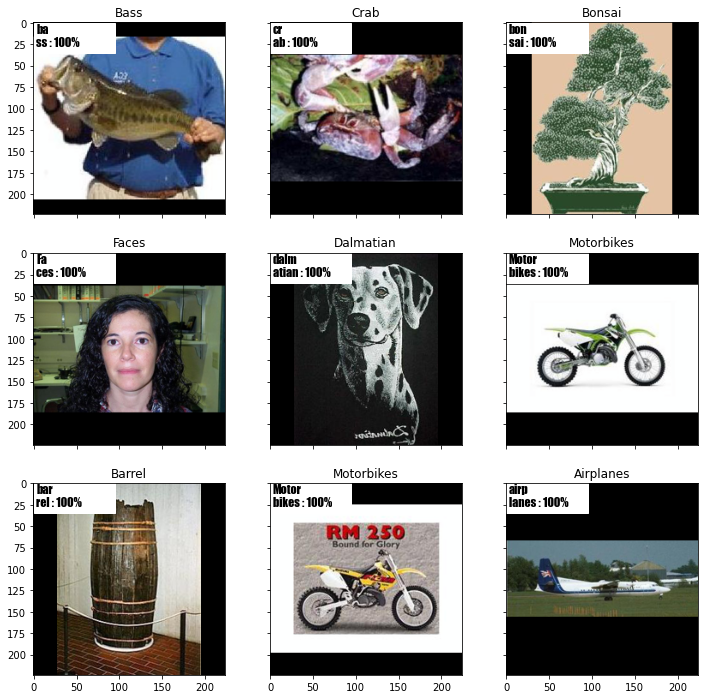

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_images = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_images]
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 0), 95, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg19, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(3, 0, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=12, color='black', fontweight='normal')